# 0. Setup

In [460]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# 1. Data Loading and Cleaning

In [461]:
raw_data = pd.read_csv('Orange Quality Data.csv')
raw_data.head()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5)
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5


In [462]:
# Check for empty values
raw_data.isnull().any()

Size (cm)             False
Weight (g)            False
Brix (Sweetness)      False
pH (Acidity)          False
Softness (1-5)        False
HarvestTime (days)    False
Ripeness (1-5)        False
Color                 False
Variety               False
Blemishes (Y/N)       False
Quality (1-5)         False
dtype: bool

There are no missing values in the data

In [463]:
# Clean up column names
raw_data.columns = [col.split(' ')[0] for col in raw_data.columns.to_list()]
raw_data.head()

,Size,Weight,Brix,pH,Softness,HarvestTime,Ripeness,Color,Variety,Blemishes,Quality
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5


In [464]:
# Get unique types of blemishes
raw_data['Blemishes'].unique()

array(['N', 'Y (Minor)', 'Y (Sunburn)', 'Y (Mold Spot)', 'Y (Bruise)',
       'Y (Split Skin)', 'Y (Sunburn Patch)', 'Y (Scars)',
       'Y (Minor Insect Damage)', 'Y (Bruising)', 'N (Minor)',
       'N (Split Skin)'], dtype=object)

There are two ways to deal with this the various types of blemishes. We can ignore the type of blemish and treat these all as a generic Y/N, or one hot encode each type of blemish. We will try the former first, then go back and try the latter after to see if it improves performance.

In [465]:
data_1 = raw_data.copy()
data_1['Blemishes'] = [row.split(' ')[0] for row in raw_data['Blemishes']]
data_1['Blemishes'].unique()

array(['N', 'Y'], dtype=object)

In [466]:
data_1.head()

,Size,Weight,Brix,pH,Softness,HarvestTime,Ripeness,Color,Variety,Blemishes,Quality
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y,4.5


# 2. Visualizations

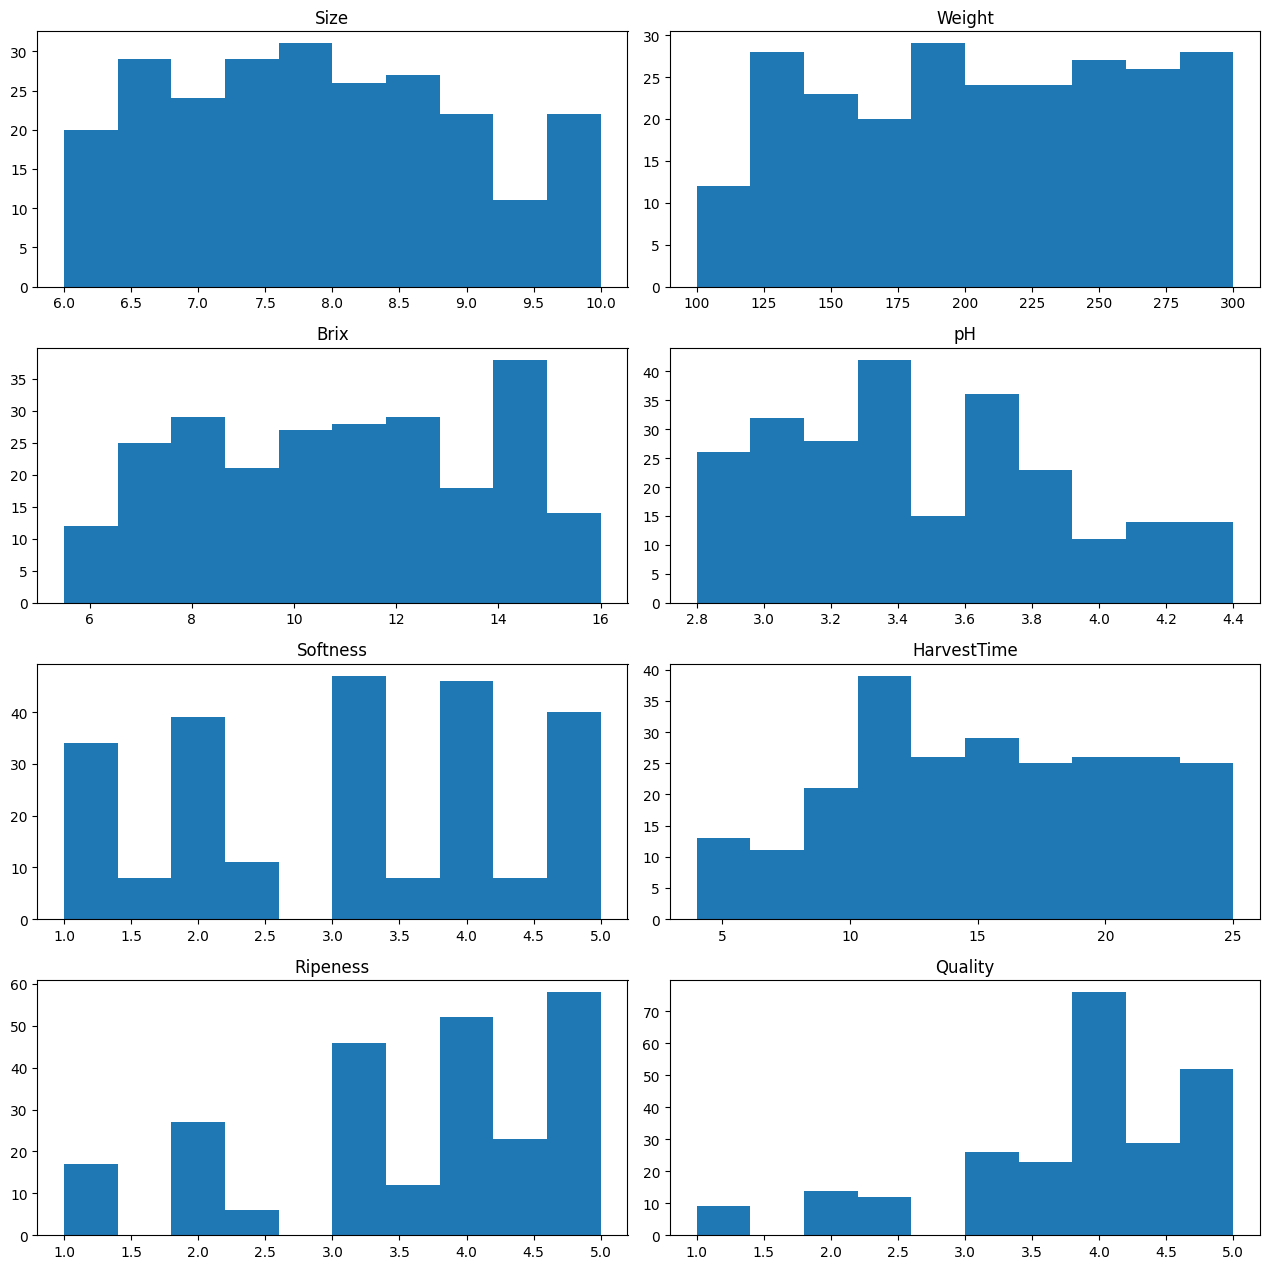

In [467]:
# Histograms of all numerical values, figure parameters are somewhat arbitrary to make it look readable
fig, ax = plt.subplots(ncols = 2, nrows = 4, figsize = [12.8, 12.8], layout = 'tight')
features_to_plot = ['Size', 'Weight', 'Brix', 'pH', 'Softness', 'HarvestTime', 'Ripeness', 'Quality']
for i in range(4):
    for j in range(2):
        ax[i, j].hist(data_1[features_to_plot[2*i + j]])
        ax[i, j].set_title(features_to_plot[2*i + j])

Ripeness and softness have a disproportionate amount of whole number ratings, and a quality of 4.0 seems to be the most common.

There are some intuitive relationships between the variables, such as size and weight having a positive relationship, so we can plot some of them against each other to verify them.

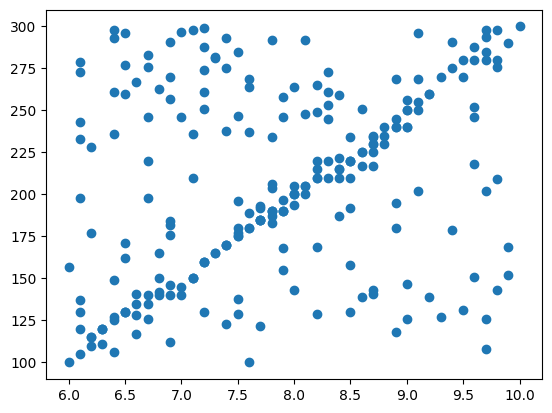

In [468]:
plt.scatter(data_1['Size'], data_1['Weight'])

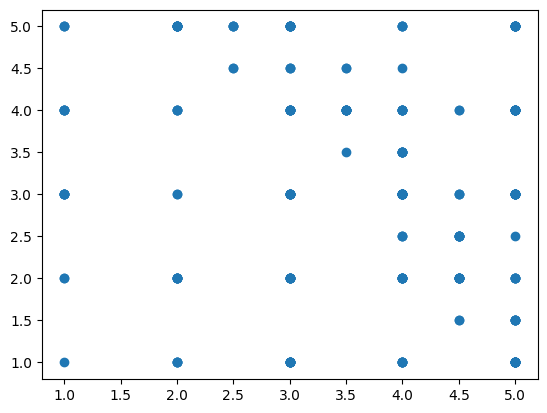

In [469]:
# This is pretty useless without jitter
plt.scatter(data_1['Ripeness'], data_1['Softness'])

Size and weight seem to have a positive correlation.

# 3. Choosing Features

Even though there aren't that many features, some of them may be irrelevant so it may be useful to try and eliminate some. We will do this with mutual information scores.

In [470]:
# Start by filling X with all features
X = data_1.copy()
y = X.pop('Quality')

In [471]:
data_1.dtypes

Size           float64
Weight           int64
Brix           float64
pH             float64
Softness       float64
HarvestTime      int64
Ripeness       float64
Color           object
Variety         object
Blemishes       object
Quality        float64
dtype: object

In [472]:
# Factor object columns
for col in X.select_dtypes('object'):
    X[col], _ = X[col].factorize()

X.dtypes

Size           float64
Weight           int64
Brix           float64
pH             float64
Softness       float64
HarvestTime      int64
Ripeness       float64
Color            int64
Variety          int64
Blemishes        int64
dtype: object

In [473]:
mi_scores = mutual_info_regression(X, y, discrete_features = X.dtypes == int)
mi_scores = pd.Series(mi_scores, index = X.columns).sort_values(ascending = False)
print(mi_scores)

Brix           0.434079
Softness       0.288758
Color          0.262963
Variety        0.231099
Ripeness       0.212214
Weight         0.192300
pH             0.159311
HarvestTime    0.156525
Blemishes      0.146225
Size           0.078770
dtype: float64


<BarContainer object of 10 artists>

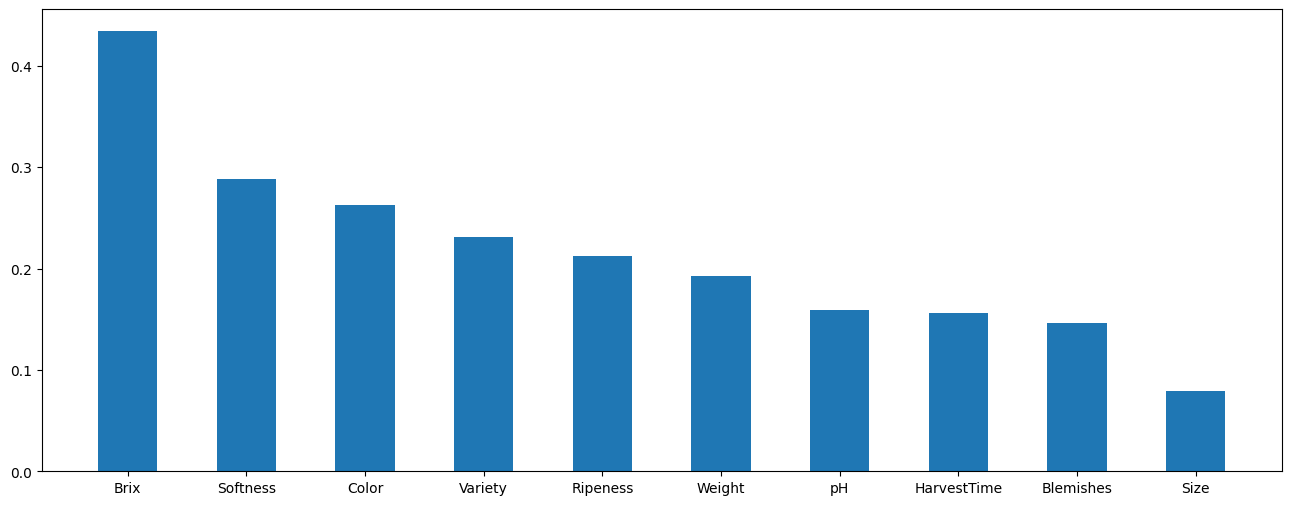

In [474]:
plt.figure(figsize=(16, 6))
plt.bar(x = mi_scores.index, height = mi_scores, width = 0.5)

We can start by eliminating size and blemishes to see how the model performs compared to using all features, though given the low amount of features the impact will likely be minimal.

# 4. Model Building

We use a random forest model first as a baseline. Since we factored the categorical variables previously, we don't need to do that again for this model. Model performance is assessed with cross-validation using the mean MAE of 5 runs.

This first model includes all features.

In [475]:
rf_model_1 = RandomForestRegressor(random_state = 1)
rf_model_1.fit(X, y)

scores = -1 * cross_val_score(rf_model_1, X, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.49426232993197283

This next model excludes size and blemishes, due to their low MI score, as well as weight due to its relationship with size.

In [476]:
X_temp = X.copy()
X_temp.pop('Size')
X_temp.pop('Weight')
X_temp.pop('Blemishes')
X_temp.head()

,Brix,pH,Softness,HarvestTime,Ripeness,Color,Variety
0,12.0,3.2,2.0,10,4.0,0,0
1,10.5,3.4,3.0,14,4.5,1,1
2,14.0,3.0,1.0,7,5.0,2,2
3,8.5,3.8,4.0,21,3.5,3,3
4,11.5,3.3,2.5,12,5.0,0,4


In [477]:
rf_model_2 = RandomForestRegressor(random_state = 1)
rf_model_2.fit(X_temp, y)

scores = -1 * cross_val_score(rf_model_2, X_temp, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.5352831632653061

Removing the low MI score features hurts the model's performance, suggesting they may have useful interactions with other variables.

# 5: Starting over with One Hot Encoding

We can try a model with one hot encoding on each categorical variable rather than ordinal. We also undo the change done to the blemishes column. Since there are no missing values, there is no need to modify any numerical values.

In [478]:
# Start by filling X with all features
X_OH = raw_data.copy()
y_OH = X_OH.pop('Quality')

# Get categorical columns
categorical_col = raw_data.select_dtypes('object').columns.to_list()

In [479]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

q = pd.DataFrame(enc.fit_transform(X_OH[categorical_col]))
q.index = X_OH.index

X_OH = pd.concat([X.drop(categorical_col, axis = 1), q], axis = 1)

X_OH.columns = X_OH.columns.astype(str)

rf_model_4 = RandomForestRegressor(random_state = 1)
rf_model_4.fit(X_OH, y_OH)

scores = -1 * cross_val_score(rf_model_4, X_OH, y_OH, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.4840297619047619

In [480]:
# Does not work correctly, but this is meant to do what was already done above using pipelines
ct = ColumnTransformer([('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_col)])
rf_model_3 = Pipeline([('processing', ct), ('rf', RandomForestRegressor(random_state = 1))])
rf_model_3.fit(X, y)

scores = -1 * cross_val_score(rf_model_3, X, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.6765700545541782

There appears to be no significant difference between the two types of categorical encoding.

# 6: Feature Importances

The first model, which generalizes blemishes, uses ordinal encoding, and includes all features, is the best so far. We can thus take a look at the feature importances in that model to see what we can imporve.

In [481]:
fi = pd.Series(data = rf_model_1.feature_importances_, index = X.columns)
print(fi.sort_values(ascending = False))

Brix           0.522982
Softness       0.148337
Ripeness       0.053848
HarvestTime    0.049171
Weight         0.046822
Variety        0.042246
Size           0.041867
pH             0.041804
Blemishes      0.036708
Color          0.016215
dtype: float64


We can try a model with just brix (sweetness) and softness to see what happens.

In [482]:
X_small = raw_data.copy()[['Brix', 'Softness']]

rf_model_5 = RandomForestRegressor(random_state = 1)
rf_model_5.fit(X_small, y)

scores = -1 * cross_val_score(rf_model_5, X_small, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.5658078663175921

It is once again worse than the first model.

# 7: XGBoost

So far, the best random forest model has had an MAE of around 0.5. We can try an XGBoost model instead of a random forest to see if we can get better predictions.

In [497]:
xgb_model_ord = XGBRegressor(n_estimators=100, learning_rate=0.02, n_jobs=8, random_state = 1)
xgb_model_ord.fit(X, y)

scores = -1 * cross_val_score(xgb_model_ord, X, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.555728174127689

In [498]:
xgb_model_OH = XGBRegressor(n_estimators=100, learning_rate=0.02, n_jobs=8, random_state = 1)
xgb_model_OH.fit(X_OH, y)

scores = -1 * cross_val_score(xgb_model_OH, X_OH, y, cv = 5, scoring = 'neg_mean_absolute_error')
scores.mean()

0.5342212629865627

# 8: Conclusion

The best model so far was the first random forest model, which included all features, used ordinal encoding for categorical variables, and generalized blemishes into a simple Y/N. The MAE for this model is roughly 0.5. A similar model which used one hot encoding instead of ordinal encoding and did everything else the same scored similarly.

This dataset is fairly simple, so it is unlikely that there are many more optimizations that can be done here.

Some notes:
- Kaggle my beloved
- I fit a lot of the models before doing cross-validation which is unnecessary but I figured it would be useful in case I wanted to analyze the model further beyond cross-validation scores and it had a negligible effect on speed
- I did a few parameter tweaks that aren't shown here because they had a negligible effect on model accuracy